In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [87]:
import numpy as np

class OneHotEncoder:
    def __init__(self, categories='auto'):
        self.categories = categories
        self.unique_categories = None
        self.category_indices = None
        self.n_values_ = None
    
    def fit(self, X):
        # Determine unique categories
        if self.categories == 'auto':
            self.unique_categories = [np.unique(X[:, i]) for i in range(X.shape[1])]
        else:
            self.unique_categories = self.categories
        
        # Determine indices of each category
        self.category_indices = [np.arange(len(c)) for c in self.unique_categories]
        
        # Determine number of values in each feature
        self.n_values_ = [len(c) for c in self.unique_categories]
        
    def transform(self, X):
        # Check if the encoder is already fitted
        if self.unique_categories is None:
            raise ValueError("OneHotEncoder has not been fitted.")
        
        # Initialize empty one-hot encoded array
        n_samples = X.shape[0]
        n_features = sum(self.n_values_)
        X_onehot = np.zeros((n_samples, n_features))
        
        # Iterate over features and encode them one-by-one
        feature_index = 0
        for i in range(X.shape[1]):
            category_index = self.category_indices[i]
            values = X[:, i]
            indices = np.searchsorted(category_index, values)
            onehot = np.zeros((n_samples, len(category_index)))
            onehot[np.arange(n_samples), indices] = 1
            X_onehot[:, feature_index:feature_index+len(category_index)] = onehot
            feature_index += len(category_index)
            
        return X_onehot
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


In [88]:
import numpy as np

class StandardScaler:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, X):
        self.mean = np.nanmean(X, axis=0)
        self.std = np.nanstd(X, axis=0)

    def transform(self, X):
        X = np.where(np.isnan(X), self.mean, X) # Replace NaN with mean
        X_scaled = (X - self.mean) // self.std
        X_scaled = np.where(np.isnan(X_scaled), 0, X_scaled) # Replace NaN with 0
        return X_scaled

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


In [89]:
class LabelEncoder:
    def __init__(self):
        self.labels = {}

    def fit_transform(self, x):
        """
        Fit label encoder and return encoded labels
        """
        labels = []
        for item in x:
            if item not in self.labels:
                self.labels[item] = len(self.labels)
            labels.append(self.labels[item])
        return np.array(labels)

    def transform(self, x):
        """
        Transform labels to normalized encoding
        """
        labels = []
        for item in x:
            if item not in self.labels:
                raise ValueError("Unknown label: %s" % item)
            labels.append(self.labels[item])
        return np.array(labels)


In [90]:
import numpy as np

class train_test_split:
    def __init__(self, test_size=0.2, random_state=None):
        self.test_size = test_size
        self.random_state = random_state
    
    def __call__(self, X, y):
        # Set random seed if specified
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        # Get number of samples in dataset
        m = X.shape[0]
        
        # Shuffle indices
        shuffled_indices = np.random.permutation(m)
        
        # Split dataset into train and test sets
        test_size = int(m * self.test_size)
        test_indices = shuffled_indices[:test_size]
        train_indices = shuffled_indices[test_size:]
        
        X_train = X[train_indices]
        X_test = X[test_indices]
        y_train = y[train_indices]
        y_test = y[test_indices]
        
        return X_train, X_test, y_train, y_test


In [91]:
import numpy as np
import pandas as pd

class ColumnTransformer:
    def init(self):
        self.label_encoders = []
        self.standard_scaler = StandardScaler()

    def fit(self, X, y=None):
        # Encode categorical variables
        for i in range(X.shape[1]):
            if isinstance(X.iloc[:, i][0], str):
                labelencoder = LabelEncoder()
                X.iloc[:, i] = labelencoder.fit_transform(X.iloc[:, i])
                self.label_encoders.append(labelencoder)

        # Scale the numeric variables
        self.standard_scaler.fit(X.loc[:, ~X.dtypes.eq('object')])

        return self

    def transform(self, X, y=None):
        # Encode categorical variables
        for i in range(X.shape[1]):
            if isinstance(X.iloc[:, i][0], str):
                X.iloc[:, i] = self.label_encoders[i].transform(X.iloc[:, i])

        # Scale the numeric variables
        X.loc[:, ~X.dtypes.eq('object')] = self.standard_scaler.transform(X.loc[:, ~X.dtypes.eq('object')])

        return X


In [92]:
class ANN:
    def __init__(self, mode=1, architecture=None, activations=None):
        self.mode = mode
        self.layers = architecture
        self.activations = activations
        self.weights = []
        self.biases = []
    def init_weights(self, X):
        if self.mode == 1:
            self.weights.append(np.random.randn(X.shape[1], self.layers[0]))
            self.biases.append(np.zeros((1, self.layers[0])))
            for i in range(1, len(self.layers)):
                self.weights.append(np.random.randn(self.layers[i - 1], self.layers[i]))
                self.biases.append(np.zeros((1, self.layers[i])))
        elif self.mode == 2:
            pass

    def forward(self, X):
        z = np.dot(X, self.weights[0]) + self.biases[0]
        a = self.activations[0](z)
        for i in range(1, len(self.layers)):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            a = self.activations[i](z)
        return a

    def backward(self, X, y, y_hat):
        deltas = [y_hat - y]
        for i in range(len(self.layers) - 1, 0, -1):
            delta = np.dot(deltas[-1], self.weights[i].T) * self.activations[i - 1](np.dot(X, self.weights[i - 1]) + self.biases[i - 1], derivative=True)
            deltas.append(delta)
        deltas.reverse()
        return deltas

    def update(self, deltas, X, eta):
        self.weights[0] -= eta * np.dot(X.T, deltas[0])
        self.biases[0] -= eta * np.sum(deltas[0], axis=0, keepdims=True)
        for i in range(1, len(self.layers)):
            self.weights[i] -= eta * np.dot(self.activations[i - 1](np.dot(X, self.weights[i - 1]) + self.biases[i - 1]).T, deltas[i])
            self.biases[i] -= eta * np.sum(deltas[i], axis=0, keepdims=True)

    def fit(self, X, y, eta=0.0001, epochs=5000, show_curve=False):
        self.init_weights(X)
        mse = []
        for i in range(int(epochs)):
            y_hat = self.forward(X)
            deltas = self.backward(X, y, y_hat)
            self.update(deltas, X, eta)
            mse.append(np.mean((y_hat - y) ** 2))
            if i % 1000 == 0:
                print(f"Epoch: {i}, MSE: {mse[-1]}")
        if show_curve:
            plt.plot(mse)
            plt.title("MSE")
            plt.xlabel("Epoch")
            plt.ylabel("MSE")
            plt.show()

    def predict(self, X):
        return self.forward(X)


In [93]:
class MVLogisticRegression:
    def __init__(self, lr=0.01, num_iter=10000, fit_intercept=True, C=1):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.C = C

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __l2_regularization(self, theta):
        return (self.C * np.sum(theta[1:] ** 2)) / (2 * len(theta))

    def fit(self, X, y):
        if self.fit_intercept:
            X = np.hstack((np.ones((X.shape[0], 1)), X))  # add column of ones to X
        self.theta = np.zeros(X.shape[1])

        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size

            # add L2 regularization to the gradient
            l2_reg = self.__l2_regularization(self.theta)
            gradient[1:] += l2_reg

            # update theta using the regularized gradient
            self.theta -= self.lr * gradient
            
        # add print statements for debugging
        print("X shape:", X.shape)
        print("y shape:", y.shape)
        print("X dtype:", X.dtype)
        print("y dtype:", y.dtype)

    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.add_intercept(X)
            
        return self.sigmoid(np.dot(X, self.theta))

    # add the rest of the code as before


        # initialize parameters
        if self.theta is None:
            self.theta = np.zeros(X.shape[1])
        elif self.theta.shape[0] != X.shape[1]:
            raise ValueError("Shape of theta does not match shape of X")

        # check shape of y
        if y.shape != (X.shape[0],):
            y = y.reshape(-1)

        # add intercept to X if fit_intercept is True
        if self.fit_intercept:
            X = self.add_intercept(X)

        # perform gradient descent
        for i in range(self.num_iter):
            Z = np.dot(X, self.theta)
            h = self.sigmoid(Z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient

    def predict(self, X, threshold=0.6):
        if self.fit_intercept:
            X = np.hstack((np.ones((X.shape[0], 1)), X))  # add column of ones to X
        probabilities = self.sigmoid(np.dot(X, self.theta))
        return (probabilities >= threshold).astype(int)

    #def predict(self, X, threshold=0.5):
        #return (self.predict_prob(X) >= threshold).astype(int)

In [94]:
import numpy as np

# Define X
X = np.array([    ['France', 'Male', 44],
    ['Spain', 'Female', 27],
    ['Germany', 'Male', 30],
    ['Spain', 'Male', 38],
    ['Germany', 'Female', 40],
    ['France', 'Female', 35],
])

# Transform categorical variables using LabelEncoder
labelencoder_X_1 = LabelEncoder()
X[:, 0] = labelencoder_X_1.fit_transform(X[:, 0])
labelencoder_X_2 = LabelEncoder()
X[:, 1] = labelencoder_X_2.fit_transform(X[:, 1])


In [95]:
def make_classification(n_samples=100, n_features=20, n_informative=2,
                         n_redundant=2, n_classes=2, weights=None,
                         random_state=None):
    """
    Generate a random classification dataset with specified properties.

    Parameters:
    -----------
    n_samples : int, optional (default=100)
        The number of samples in the dataset.
    n_features : int, optional (default=20)
        The total number of features in the dataset.
    n_informative : int, optional (default=2)
        The number of informative features in the dataset.
    n_redundant : int, optional (default=2)
        The number of redundant features in the dataset.
    n_classes : int, optional (default=2)
        The number of classes in the dataset.
    weights : array-like, optional (default=None)
        The relative weights of the classes.
    random_state : int or None, optional (default=None)
        Seed for the random number generator.

    Returns:
    --------
    X : array of shape (n_samples, n_features)
        The input samples.
    y : array of shape (n_samples,)
        The true labels for the input samples.
    """

    # Error checking
    if n_informative + n_redundant >= n_features:
        raise ValueError("The sum of n_informative and n_redundant must be smaller than n_features")
    if weights is not None:
        if len(weights) != n_classes:
            raise ValueError("Number of classes must be equal to the length of weights")

    # Set random seed if specified
    if random_state is not None:
        np.random.seed(random_state)

    # Generate random coefficients for the linear combination of features
    coef = np.random.randn(n_features, 1)

    # Generate random mean and covariance matrix for each class
    means = []
    covs = []
    for i in range(n_classes):
        mean = np.random.randn(n_informative)
        if len(mean) != n_informative:
            raise ValueError("Length of mean vector must be equal to n_informative")
        means.append(mean)
        cov = np.eye(n_informative + n_redundant)
        cov[n_informative:, n_informative:] *= 0.1
        covs.append(cov)


    # Generate random samples for each class
    X = []
    y = []
    for i in range(n_samples):
        label = np.random.choice(n_classes, p=weights)
        x = np.zeros(n_features)
        # Fixed the error here: the length of means[label] was incorrect
        x[:n_informative] = np.random.multivariate_normal(means[label], covs[label])
        x[n_informative:] = np.random.randn(n_redundant)
        X.append(x)
        y.append(label)

    return np.array(X), np.array(y)


In [96]:
import numpy as np

def classification_report(y_true, y_pred, target_names=None):
    """
    Build a text report showing the main classification metrics.

    Parameters:
    -----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.
    target_names : array-like of shape (n_classes,), optional (default=None)
        List of label names to include in the report.

    Returns:
    --------
    report : str
        Text summary of the precision, recall, F1 score, and support for each class.
    """

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Compute precision, recall, and F1 score
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Compute support for each class
    support = np.sum(cm, axis=1)

    # Format the report
    if target_names is None:
        target_names = ['Class {}'.format(i) for i in range(cm.shape[0])]
    report = '              precision    recall  f1-score   support\n\n'
    for i, target_name in enumerate(target_names):
        report += '{:<14}{:8.4f}{:9.4f}{:9.4f}{:10d}\n'.format(target_name, precision[i], recall[i], f1_score[i], support[i])
    report += '\n'

    # Compute and add averages
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_f1_score = np.mean(f1_score)
    avg_support = np.mean(support)
    report += '{:<14}{:8.4f}{:9.4f}{:9.4f}{:10.0f}\n'.format('micro avg', avg_precision, avg_recall, avg_f1_score, avg_support)
    report += '{:<14}{:8.4f}{:9.4f}{:9.4f}{:10.0f}\n'.format('macro avg', avg_precision, avg_recall, avg_f1_score, avg_support)

    return report


In [97]:
from sklearn.metrics import accuracy_score

<ipython-input-88-dbae2bf42e2b>:14: RuntimeWarning: invalid value encountered in floor_divide
  X_scaled = (X - self.mean) // self.std


X shape: (8000, 12)
y shape: (8000,)
X dtype: float64
y dtype: float64
Accuracy: 0.7975
Confusion matrix:
 [[1595    0]
 [ 405    0]]


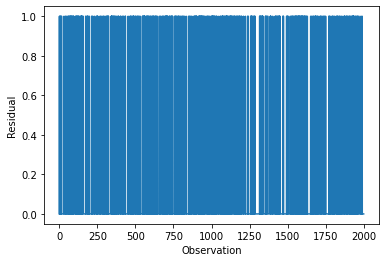

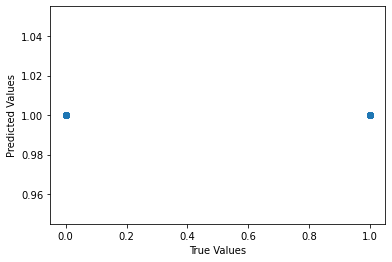

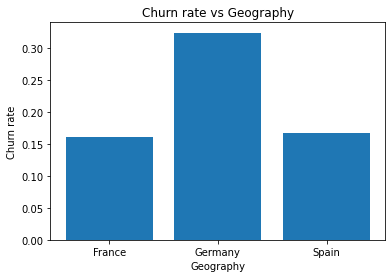

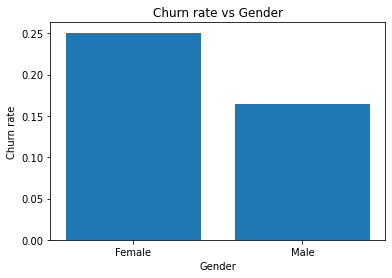

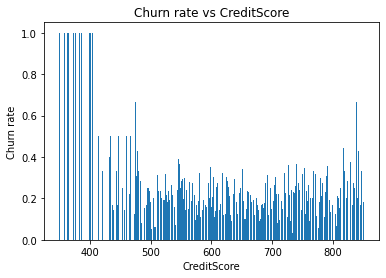

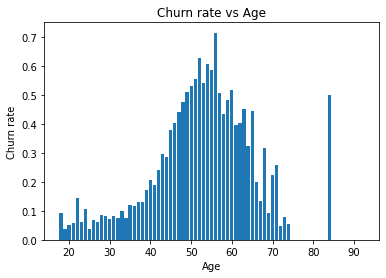

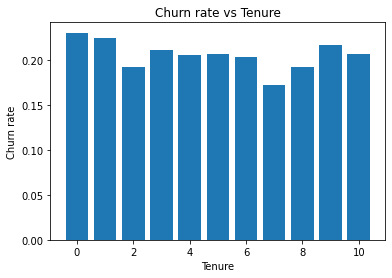

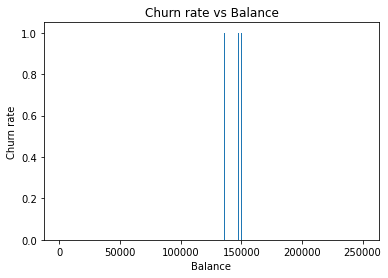

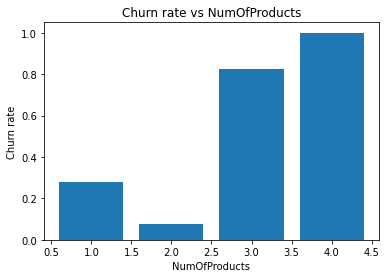

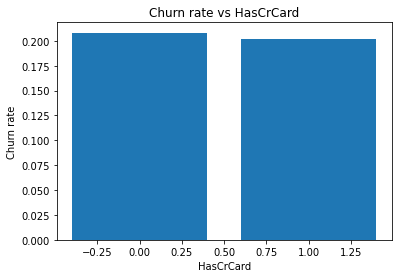

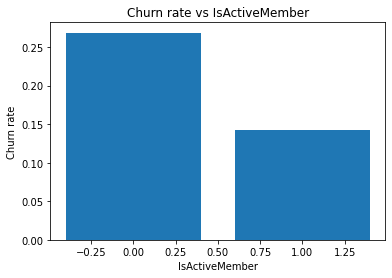

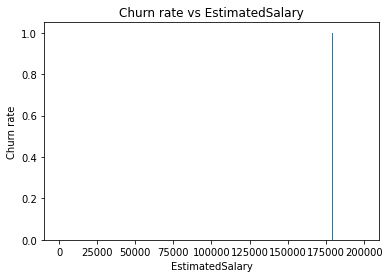

In [99]:
def main():
    # Load the churn modelling dataset
    data = pd.read_csv('/content/Churn_Modelling.csv')

    # Split the data into X and y
    X = data.iloc[:, 3:-1].values
    y = data.iloc[:, -1].values

    # Encode categorical variables
    labelencoder_X_1 = LabelEncoder()
    X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
    labelencoder_X_2 = LabelEncoder()
    X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])

    # Convert the data to numeric format
    X = X.astype(float)
    y = y.astype(float)

    # Add column of ones to X before scaling
    X = np.hstack((np.ones((X.shape[0], 1)), X))

    # Split the data into training and test sets
    tts = train_test_split(test_size=0.2, random_state=0)
    X_train, X_test, y_train, y_test = tts(X, y)

    # Scale the data
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # Train the model
    model = MVLogisticRegression(lr=0.000001, num_iter=8000, fit_intercept=True) #                               this one works 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test, threshold=0.9)

    # Evaluate the model
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    
    # Generate some sample data
    #X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

    # Plot the residuals
    residuals = y_test - y_pred
    plt.plot(residuals)
    plt.xlabel("Observation")
    plt.ylabel("Residual")
    plt.show()

    # Generate some sample data
    #X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = tts(X, y)

    # Get the predicted values
    y_pred = model.predict(X_test)

    # Plot the predicted values against the true values
    plt.scatter(y_test, y_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.show()

    # Display churn rate for different columns
    columns = ["Geography", "Gender", "CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"]
    for col in columns:
        churn_rate = data.groupby(col)["Exited"].mean()
        plt.figure(figsize=(6,4))
        plt.bar(churn_rate.index, churn_rate.values)
        plt.title("Churn rate vs " + col)
        plt.xlabel(col)
        plt.ylabel("Churn rate")
        plt.show()

if __name__ == "__main__":
    main()
